# Link Google Drive data and load required libraries

Mount Google Drive to access files


In [1]:
from google.colab import drive
import os
drive.mount('/content/gdrive/')
os.chdir('/content/gdrive/My Drive/LLR_NN')
!ls
!pip install tensorflow-gpu==2.1.0

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/
BPSK_X_test_var_0.1.csv   BPSK_y_train_var_0.1.csv  QPSK_X_valid_var_0.1.csv
BPSK_X_train_var_0.1.csv  BPSK_y_valid_var_0.1.csv  QPSK_y_test_var_0.1.csv
BPSK_X_valid_var_0.1.csv  QPSK_X_test_var_0.1.csv   QPSK_y_train_var_0.1.csv
BPSK_y_test_var_0.1.csv   QPSK_X_train_var_0.1.csv  QPSK_y_valid_var_0.1.csv
     |████████████████████████████████| 421.8MB 38kB/s 
     |████████████████████████████████| 450kB 51.6MB/s 
     |████████████████████████████████| 3.9

Import Required Libaries

In [0]:
import numpy as np
import scipy.io as sio
import sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, MaxPooling1D
from tensorflow.keras.layers import Activation,Conv2D, Flatten, Permute, Cropping2D
from tensorflow.keras.layers import ZeroPadding2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Reshape
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
import matplotlib.pyplot as plt

Load Data

In [3]:
MODULATION = "QPSK"
NOISE_VAR = "0.1"

# Load the training data
X_train = np.genfromtxt(MODULATION + "_X_train_var_" + NOISE_VAR + ".csv", delimiter=',')
y_train= np.genfromtxt(MODULATION + "_y_train_var_" + NOISE_VAR + ".csv", delimiter=',')

# Load validation error
X_valid = np.genfromtxt(MODULATION + "_X_valid_var_" + NOISE_VAR + ".csv", delimiter=',')
y_valid= np.genfromtxt(MODULATION + "_y_valid_var_" + NOISE_VAR + ".csv", delimiter=',')

# Load the test data
X_test = np.genfromtxt(MODULATION + "_X_test_var_" + NOISE_VAR + ".csv", delimiter=',')
y_test = np.genfromtxt(MODULATION + "_y_test_var_" + NOISE_VAR + ".csv", delimiter=',')

X_train = X_train.T
X_valid = X_valid.T
X_test = X_test.T

y_train = y_train.T
y_valid = y_valid.T
y_test = y_test.T

if(len(y_train.shape) == 1):
  y_train = y_train.reshape([-1,1])
  y_valid = y_valid.reshape([-1,1])
  y_test = y_test.reshape([-1,1])

print("Training data shape: \t\t", X_train.shape)
print("Validation data shape: \t\t",X_valid.shape)
print("Test data shape: \t\t" ,X_test.shape)

print("Training label shape: \t\t", y_train.shape)
print("Training label shape: \t\t", y_valid.shape)
print("Training label shape: \t\t", y_test.shape)

Training data shape: 		 (10000, 2)
Validation data shape: 		 (1500, 2)
Test data shape: 		 (500, 2)
Training label shape: 		 (10000, 2)
Training label shape: 		 (1500, 2)
Training label shape: 		 (500, 2)


# Construct Fully Connected Neural Net


Define the model. Note that we have multiple outputs corresponding to each bit LLR.

In [73]:
model_input = Input(shape=(X_train.shape[1]), name='model_input')
num_outputs = y_train.shape[1]
num_layers = 7

x = Dense(512, activation='relu')(model_input)
for i in range(num_layers, 1, -1):
  x = Dense(max(num_outputs, 2**i), activation="relu")(x)

output_vec = [None]*num_outputs
for i in range(num_outputs):
  out_layer_name = "LLR_bit_" + str(i+1)
  output_vec[i] = Dense(1, activation = "linear", name = out_layer_name)(x)

model = Model(inputs = model_input, outputs = output_vec)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_input (InputLayer)        [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_54 (Dense)                (None, 512)          1536        model_input[0][0]                
__________________________________________________________________________________________________
dense_55 (Dense)                (None, 128)          65664       dense_54[0][0]                   
__________________________________________________________________________________________________
dense_56 (Dense)                (None, 64)           8256        dense_55[0][0]                   
____________________________________________________________________________________________

Train the model

In [0]:
model.compile(loss='logcosh',
              optimizer = optimizers.Nadam(),
              metrics = ['mean_squared_error'])

y_train_flattened = [None] * num_outputs
y_valid_flattened = [None] * num_outputs
y_test_flattened = [None] * num_outputs

for i in range(num_outputs):
  y_train_flattened[i] = y_train[:,i]
  y_valid_flattened[i] = y_valid[:,i]
  y_test_flattened[i] = y_test[:,i]

history = model.fit(X_train, y_train_flattened, validation_data=(X_valid, y_valid_flattened), batch_size=100, epochs=50, verbose = 0)

Evaluate the Model

In [59]:
score_val = model.evaluate(X_valid, y_valid_flattened, batch_size = 100, verbose=1)
score_test = model.evaluate(X_test, y_test_flattened, batch_size = 100, verbose=1)

print("Evaluate model on the validation set:")
print("---------------------------------------------------")
print("Total Loss: \t\t\t", score_val[0])
for i in range(num_outputs):
  print("Bit " + str(i) + " [Loss, MSE] is: \t\t", score_val[i+1], "\t, ", score_val[i+3])

print("\n\nEvaluate model on the test set:")
print("---------------------------------------------------")
print("Total Loss: \t\t\t", score_test[0])
for i in range(num_outputs):
  print("Bit " + str(i) + " [Loss, MSE] is: \t\t", score_test[i+1], "\t, ", score_test[i+3])

500/500 [==============================] - 0s 48us/sample - loss: 0.1017 - LLR_bit_1_loss: 0.0548 - LLR_bit_2_loss: 0.0469 - LLR_bit_1_mean_squared_error: 0.1130 - LLR_bit_2_mean_squared_error: 0.0967
Evaluate model on the validation set:
---------------------------------------------------
Total Loss: 			 0.107615893582503
Bit 0 [Loss, MSE] is: 		 0.058358464 	,  0.12061621
Bit 1 [Loss, MSE] is: 		 0.04925743 	,  0.10186622


Evaluate model on the test set:
---------------------------------------------------
Total Loss: 			 0.10172119438648224
Bit 0 [Loss, MSE] is: 		 0.0548257 	,  0.11298149
Bit 1 [Loss, MSE] is: 		 0.046895497 	,  0.09672506


Plot the LLRs acquired from the neural net vs actual LLRs

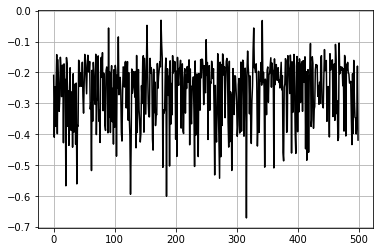

In [47]:
y_pred = [None]*num_outputs
y_pred = model.predict(X_test)

plt.plot(np.asarray(y_pred[0][:]) - y_test[:,0].reshape([-1,1]), 'k')
plt.grid()
plt.show()